In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn.functional as F
from torch import Tensor
from datetime import datetime
import math
import random
import numpy as NP
import matplotlib.pyplot as plt
%matplotlib inline
relPath = "../../"
import sys
sys.path.append(relPath)
from mm.printing import *
from network import *
from neural import *

In [2]:
initLogging("Common init")

dtype = torch.float
log("dtype", dtype)

dvc = torch.device("cpu")
log("device", dvc.type)

contextSize = 3
log("contextSize", contextSize)

Common init:         -------------------------- 2023-07-21 17:04:36
dtype:               torch.float32
device:              cpu
contextSize:         3


In [3]:
logSection("Prepare data")

filePath = relPath + "data/names.txt"
log("filePath", filePath)

ldr = loadData(filePath)
printDataInfo(ldr)


Prepare data:        -------------------------- 2023-07-21 17:04:36
filePath:            ../../data/names.txt
First few words:     ['emma', 'olivia', 'ava', 'isabella', 'sophia']
Words counts:        32033
Vocabulary:          ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi:                {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itos:                {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
Vocabulary + end length: 27
random probability:  3.2958


In [4]:
logSection("Prepare dataset")

wordShufflingSeed = 42
log("wordShufflingSeed", wordShufflingSeed)
random.seed(wordShufflingSeed)
random.shuffle(ldr.words)

ds = buildDataSet(ldr, contextSize, 0.8, 0.9, torch.int64, dvc)

Prepare dataset:     -------------------------- 2023-07-21 17:04:36
wordShufflingSeed:   42
data dtype:          torch.int64
trRatio:             0.8
devRatio:            0.9
Training:            length 25626 shape [182625, 3] ['yuheng', 'diondre', 'xavien']
Validation:          length 3203 shape [22655, 3] ['amay', 'aytana', 'jenevi']
Test:                length 3204 shape [22866, 3] ['mustafa', 'reuben', 'kahlel']


Build network:       -------------------------- 2023-07-21 17:04:38
embeddingDims:       10
hiddenLayerSize:     100
learningSeed:        2147483647
W1ratio:             0.3042903097250923
b1ratio:             0.01
W2ratio:             0.1
b2ratio:             0
parametersCount:     6197


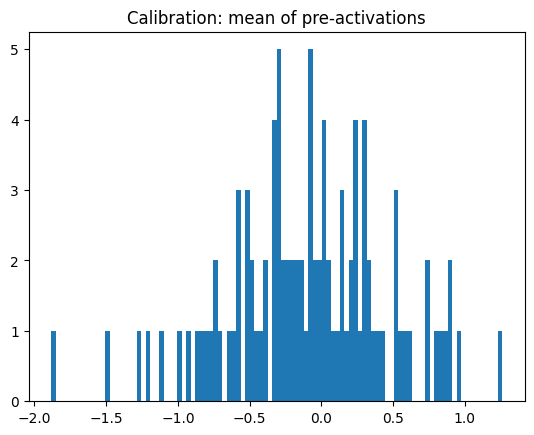

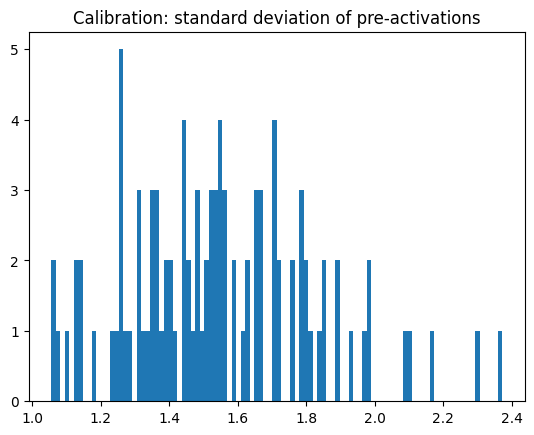

In [5]:
logSection("Build network")

embeddingDims = 10
log("embeddingDims", embeddingDims)

hiddenLayerSize = 100
log("hiddenLayerSize", hiddenLayerSize)

learningSeed = 2147483647
log("learningSeed", learningSeed)
g = torch.Generator(device=dvc).manual_seed(learningSeed)

np = makeNetwork(g, len(ldr.stoi), embeddingDims, contextSize, hiddenLayerSize, dvc)
log("parametersCount", sum(p.nelement() for p in np.all))

cal = calibrateBatchNorm(np, ds.tr.x)

plt.figure()
plt.hist(cal.mean.tolist(), 100)
plt.title("Calibration: mean of pre-activations")

plt.figure()
plt.hist(cal.std.tolist(), 100)
plt.title("Calibration: standard deviation of pre-activations")

@torch.no_grad()
def trLoss(): return getLoss(np, cal, np.C[ds.tr.x], ds.tr.y)

@torch.no_grad()
def valLoss(): return getLoss(np, cal, np.C[ds.val.x], ds.val.y)

@torch.no_grad()
def tstLoss(): return getLoss(np, cal, np.C[ds.tst.x], ds.tst.y)

def getLosses() -> Losses:
    l = Losses()
    l.tr = trLoss()
    l.val = valLoss()
    l.tst = tstLoss()
    return l

def logLosses():
    losses = getLosses()
    l1 = f"{losses.tr.loss.item():>10.4f}"
    l2 = f"{losses.val.loss.item():>10.4f}"
    l3 = f"{losses.tst.loss.item():>10.4f}"
    logSimple(f"{l1} {l2} {l3}")

Learning:            -------------------------- 2023-07-21 17:04:56
trainingBatchSize:   32
trainingSteps: :     5708
maxIteration:        200000
repeats:             36
maxLr:               0.14
minLr:               0.0001
actualIterations:    200000
  0,      0 losses:     0.0000       3.4607     3.4640     3.4640
  1,   5708 losses:     2.3972       2.2923     2.3026     2.2986


KeyboardInterrupt: 

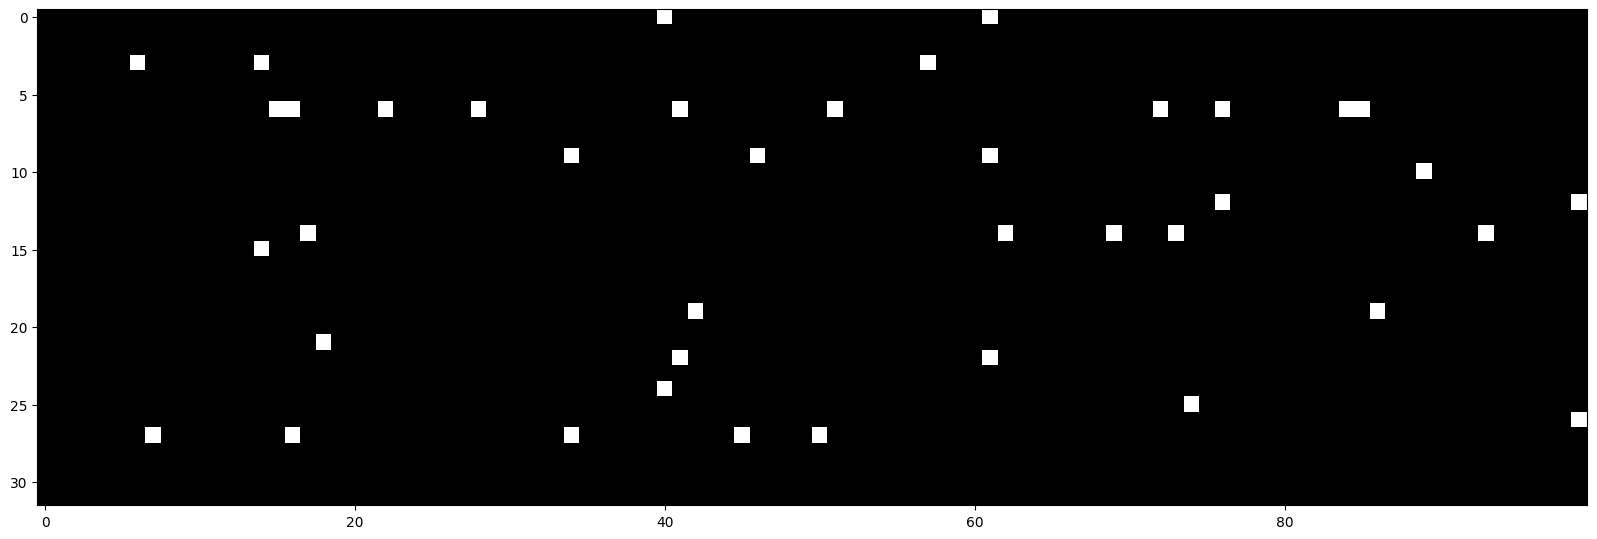

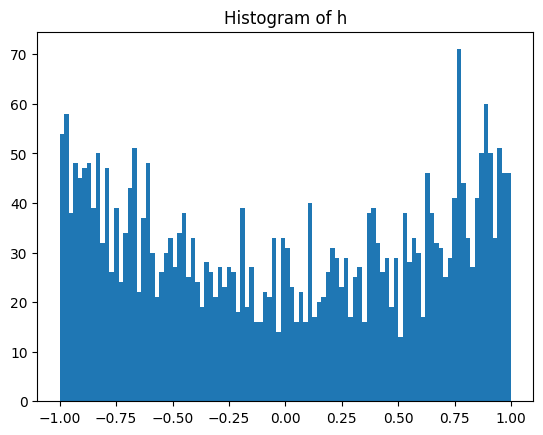

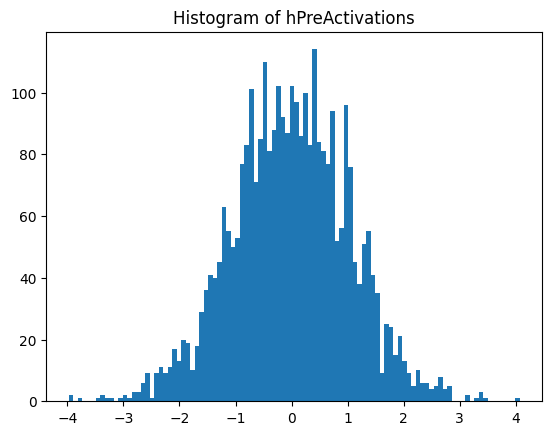

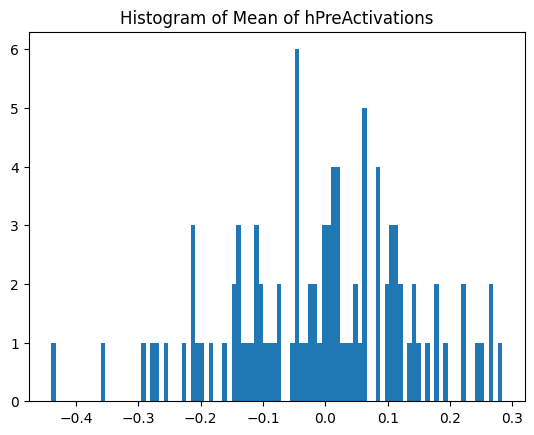

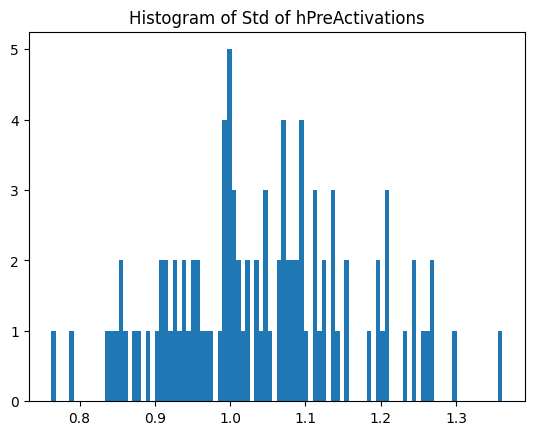

In [6]:
logSection("Learning")

trainingBatchSize = 32
log("trainingBatchSize", trainingBatchSize)

trXLength = ds.tr.x.shape[0]
trainingSteps = (trXLength // trainingBatchSize) + 1
log ("trainingSteps: ", trainingSteps)

maxIteration = 200_000
log("maxIteration", maxIteration)

repeats = 36
log("repeats",repeats)

maxLr = 0.14
log("maxLr", maxLr)

minLr = 0.0001
log("minLr", minLr)

actualIterations = min(maxIteration, repeats * math.ceil(trXLength / trainingBatchSize))
log("actualIterations", actualIterations)

lrAtIx: list[float] = []
stepIx: list[int] = []
lossAtIx: list[float] = []
logLossAtIx: list[float] = []
up = UpdateNetResult()
fr = ForwardPassResult()
fr.loss = torch.tensor(0)
i = 0
lr = 0.1;
lre = torch.linspace(-3, 0, trainingSteps)
lrs = 10 ** lre

for repeat in range(repeats):
    
    if i >= maxIteration:
        break;

    logSimple(f"{repeat:>3}, {i:>6} losses: {fr.loss.item():>10.4f}   ", end="")
    logLosses()

    for start in range(0, trXLength, trainingBatchSize):

        if i >= maxIteration:
            log("Break at max iteration")
            break;
        
        end = min(start + trainingBatchSize, trXLength)
        #miniBatchIxs = torch.arange(start, end)
        miniBatchIxs = torch.randint(0, trXLength, (trainingBatchSize,), generator=g, device=dvc)
        fr = forwardPass(np, cal, ds.tr.x, ds.tr.y, miniBatchIxs)
        backwardPass(np.all, fr.loss)

        if i == 1:
            plt.figure(figsize=(20, 10))
            plt.imshow(fr.h.abs() > 0.99, cmap="gray", interpolation="nearest")
            
            plt.figure()
            plt.hist(fr.h.view(-1).tolist(), 100)
            plt.title('Histogram of h')

            plt.figure()
            plt.hist(fr.hPreActivations.view(-1).tolist(), 100)
            plt.title('Histogram of hPreActivations')

            plt.figure()
            plt.hist(fr.hPreActivations.mean(0, keepdim=True).view(-1).tolist(), 100)
            plt.title('Histogram of Mean of hPreActivations')

            plt.figure()
            plt.hist(fr.hPreActivations.std(0, keepdim=True).view(-1).tolist(), 100)
            plt.title('Histogram of Std of hPreActivations')

        up = updateNet(np.all, i, actualIterations, maxLr, minLr)
        lrAtIx.append(up.learningRate)

        stepIx.append(i)
        lossAtIx.append(fr.loss.item())
        logLossAtIx.append(fr.loss.log10().item())

        #lr = lrs[i].item()
        #lrAtIx.append(lrs[i].item())
        
        i += 1

logSimple(f" final losses: {fr.loss.item():>15.4f}   ", end="")
logLosses()

#bestLr = lrs[findLowestIndex(lossAtIx)].item();
#log("best learning rate", bestLr)
log("emb.shape", fr.emb.shape)
#log("h.shape", fr.h.shape)
log("logits.shape", fr.logits.shape)

In [7]:
logSection("Sampling")

samplingSeed = learningSeed + 10
gSampling = torch.Generator(device=dvc).manual_seed(samplingSeed)
log("samplingSeed", samplingSeed)

maxSampleLength = 50
log("maxSampleLength", maxSampleLength)

Sampling:            -------------------------- 2023-07-21 17:05:08
samplingSeed:        2147483657
maxSampleLength:     50


In [8]:
samples = sampleMany(np, cal, gSampling, contextSize, ldr.itos, 20, maxSampleLength)
for s in samples:
    logSimple(f"{''.join(s.values):<21}{(s.prob * 10000):>4.0f}: ", end="")
    for p in s.probs:
        logSimple(f"{(p / (1 / 27) * 10):.0f} ", end="")
    logSimple()

eriah.                247: 21 23 77 51 65 257 
myaz.                  52: 11 10 33 3 131 
seel.                 144: 17 26 13 87 115 
ndhayah.               35: 9 1 4 101 7 47 57 248 
rethr.                 78: 17 47 8 49 7 36 
jendraeg.             153: 38 74 53 6 32 45 19 3 29 
adelynnelii.          314: 41 38 43 112 56 173 144 29 24 44 5 71 
eli.                  250: 21 94 90 25 
jen.                  369: 38 74 53 24 
eden.                 191: 21 10 35 84 173 
estanar.               98: 21 18 44 53 32 11 4 109 
elynn.                357: 21 94 30 173 144 196 
sotel.                116: 17 25 14 49 46 74 
nyshubrrgiagries.      30: 9 33 25 62 8 5 91 3 1 31 37 3 48 73 88 21 191 
jenie.                449: 38 74 53 44 55 157 
jelionnie.            312: 38 74 38 74 9 79 42 41 55 157 
cayubeka.              48: 11 98 25 1 10 49 10 77 125 
der.                  130: 9 104 31 129 
jayleyeh.             185: 38 135 33 53 83 19 2 4 107 
ylae.                  14: 2 14 90 7 84 


In [9]:
def printProb(txt: str):
    ps = calcProb(np, cal, txt, contextSize, ldr.stoi)
    op = calcOneProb(ps)
    logSimple(f"{txt:<21}{(op * 10000):<7.0f}: ", end="")
    for p in ps:
        logSimple(f"{(p / (1 / 27) * 10):.0f} ", end="")
    logSimple()

printProb('.')
printProb('m.')
printProb('mi.')
printProb('mic.')
printProb('mich.')
printProb('micha.')
printProb('michal.')
printProb('michael.')
printProb('michaela.')
printProb('michaella.')
printProb('michel.')
printProb('michalx.')
printProb('michalxx.')
printProb('michalxxx.')
printProb('martin.')
printProb('andrej.')
printProb('andrey.')
printProb('joey.')
printProb('james.')
printProb('xin.')
printProb('maxim.')
printProb('alex.')
printProb('alexa.')

.                    7      : 0 
m.                   8      : 11 0 
mi.                  40     : 11 31 2 
mic.                 41     : 11 31 27 2 
mich.                75     : 11 31 27 35 31 
micha.               86     : 11 31 27 35 158 21 
michal.              85     : 11 31 27 35 158 31 35 
michael.             90     : 11 31 27 35 158 14 92 71 
michaela.            83     : 11 31 27 35 158 14 92 26 73 
michaella.           93     : 11 31 27 35 158 14 92 22 83 177 
michel.              91     : 11 31 27 35 32 114 72 
michalx.             23     : 11 31 27 35 158 31 0 5 
michalxx.            24     : 11 31 27 35 158 31 0 2 44 
michalxxx.           13     : 11 31 27 35 158 31 0 2 0 5 
martin.              116    : 11 162 75 10 43 55 151 
andrej.              197    : 41 29 60 37 48 1 53 
andrey.              325    : 41 29 60 37 48 35 69 
joey.                195    : 38 33 16 5 97 
james.               298    : 38 135 22 70 9 64 
xin.                 8      : 1 49 34 37 
maxim.  

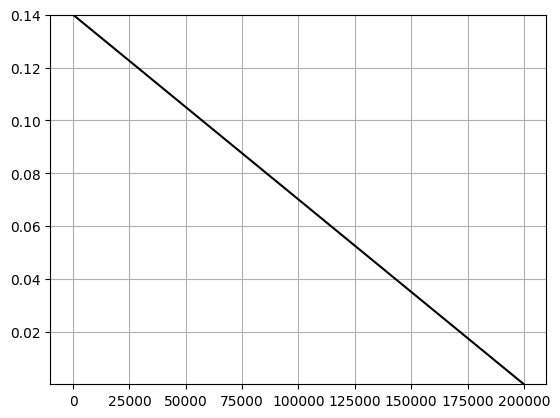

Actual min max LR 0.14 0.0001006994999999955


In [10]:
plt.plot(range(len(lrAtIx)), lrAtIx, "black")
plt.ylim(min(lrAtIx), max(lrAtIx))
plt.grid(True)
plt.show()
print("Actual min max LR", max(lrAtIx), min(lrAtIx))

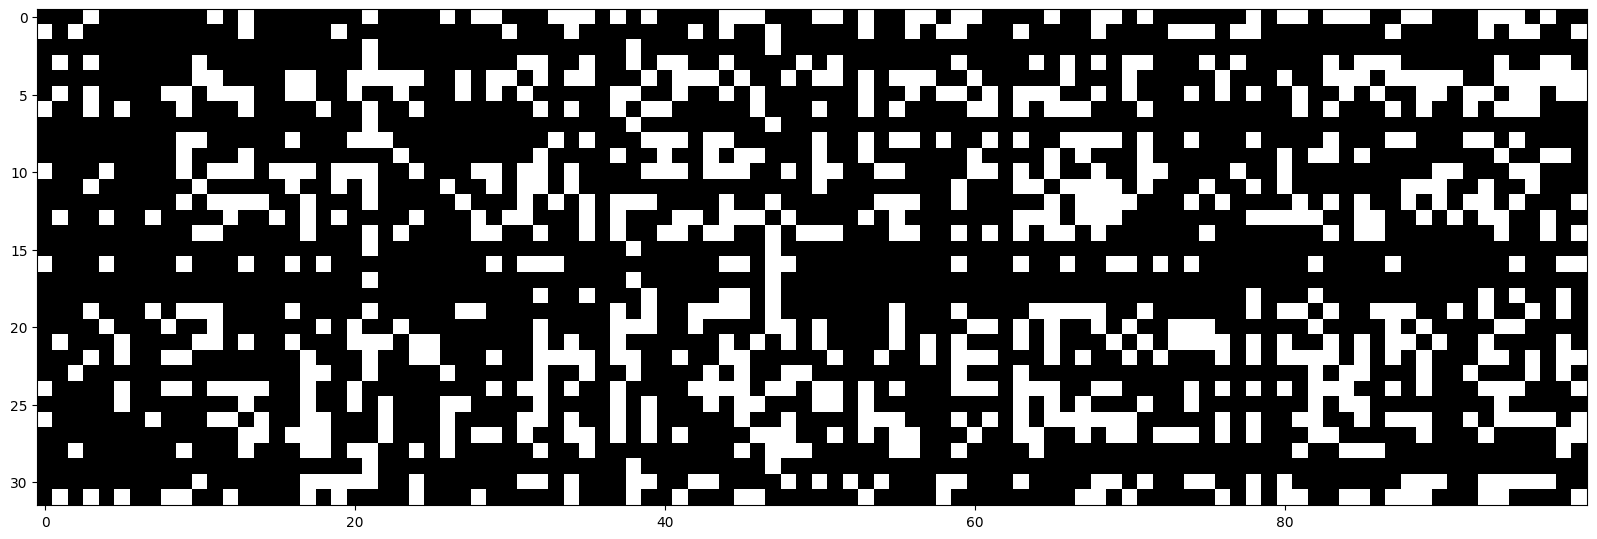

In [11]:
plt.figure(figsize=(20,10))
plt.imshow(fr.h.abs() > 0.99, cmap="gray", interpolation="nearest")

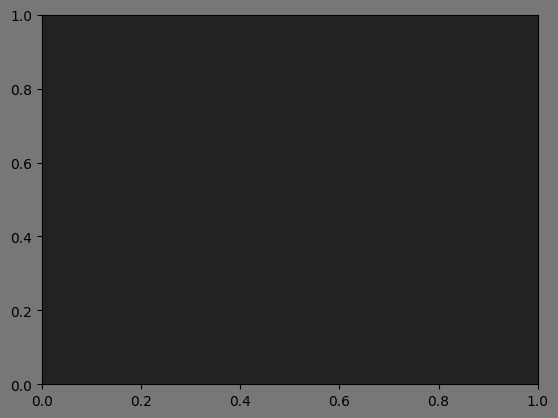

In [12]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
#ax.plot(lrAtIx, lossAtIx)
plt.show()

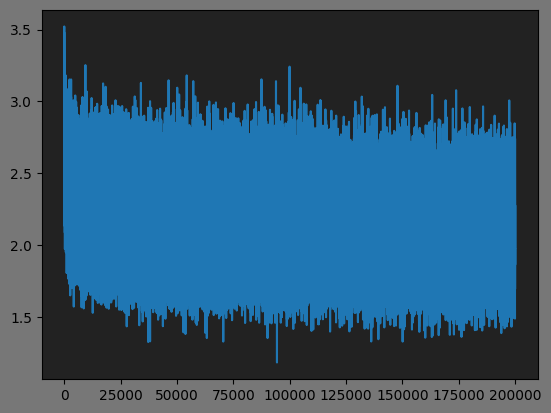

In [13]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
ax.plot(stepIx, lossAtIx)
plt.show()

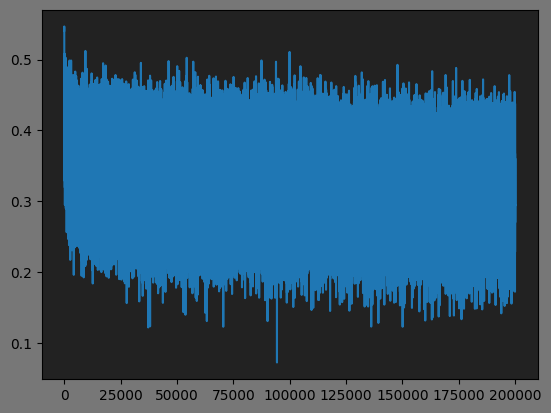

In [14]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
ax.plot(stepIx, logLossAtIx)
plt.show()

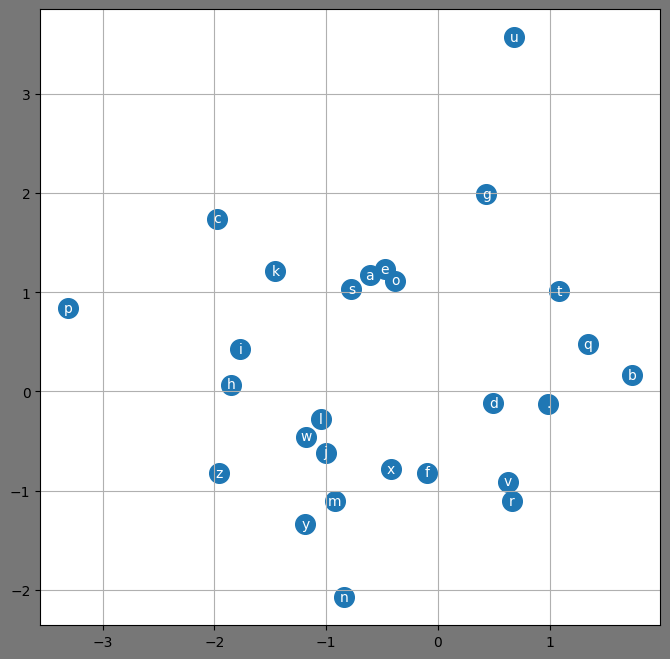

In [15]:
dim = 0
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("#777777")
sc = plt.scatter(np.C[:, dim].data, np.C[:,dim + 1].data, s=200)
for i in range(np.C.shape[0]):
    plt.text(np.C[i, dim].item(), np.C[i, dim + 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid()

In [59]:
#np.C.shape, trX.shape, np.C[trX].shape, np.C[:5], trX[:5], np.C[trX][:5]

In [16]:
# Let"s suppose these are your lists
C = [
[ 0.8774, -0.6801],
         [ 0.1651, -0.5025],
         [ 0.2769, -0.3570],
         [-0.8820,  0.3902],
         [-0.4824,  0.8744],
         [-0.3190,  0.7807],
         [-0.0100, -0.3401],
         [ 0.9975,  2.8280],
         [ 0.9623, -1.3172],
         [ 0.2180, -0.3820],
         [ 0.6139, -0.4287],
         [-0.7386,  0.5880],
         [-0.3088,  0.9816],
         [ 0.3907, -0.4174],
         [-0.7380,  0.5205],
         [-0.5288,  0.7074],
         [-0.3956,  0.9625],
         [-0.3802, -0.3504],
         [-0.2861,  0.7589],
         [ 0.5309, -0.5105],
         [-0.0922, -0.6410],
         [-0.3823,  0.9899],
         [ 0.0965, -0.5708],
         [-0.8582, -1.3429],
         [-0.4960,  0.2842],
         [-0.6105,  0.1336],
         [-0.2623,  0.2942]
]
trX = [
    [0, 0, 0],
    [0, 0, 22],
    [0, 22, 9],
    [22, 9, 15],
    [9, 15, 12],
    # ... More values
]

# We create a new list to hold the result
result = []

# We loop over each element in trX
for i in range(len(trX)):
    temp = []
    # Then we loop over each value in the element
    for j in range(len(trX[i])):
        # We use the value as an index to get the corresponding data from C
        temp.append(C[trX[i][j]])
    # We add the result to our new list
    result.append(temp)

# Let"s log the first 5 elements of the result list
for i in range(5):
    print(result[i])

[[0.8774, -0.6801], [0.8774, -0.6801], [0.8774, -0.6801]]
[[0.8774, -0.6801], [0.8774, -0.6801], [0.0965, -0.5708]]
[[0.8774, -0.6801], [0.0965, -0.5708], [0.218, -0.382]]
[[0.0965, -0.5708], [0.218, -0.382], [-0.5288, 0.7074]]
[[0.218, -0.382], [-0.5288, 0.7074], [-0.3088, 0.9816]]
